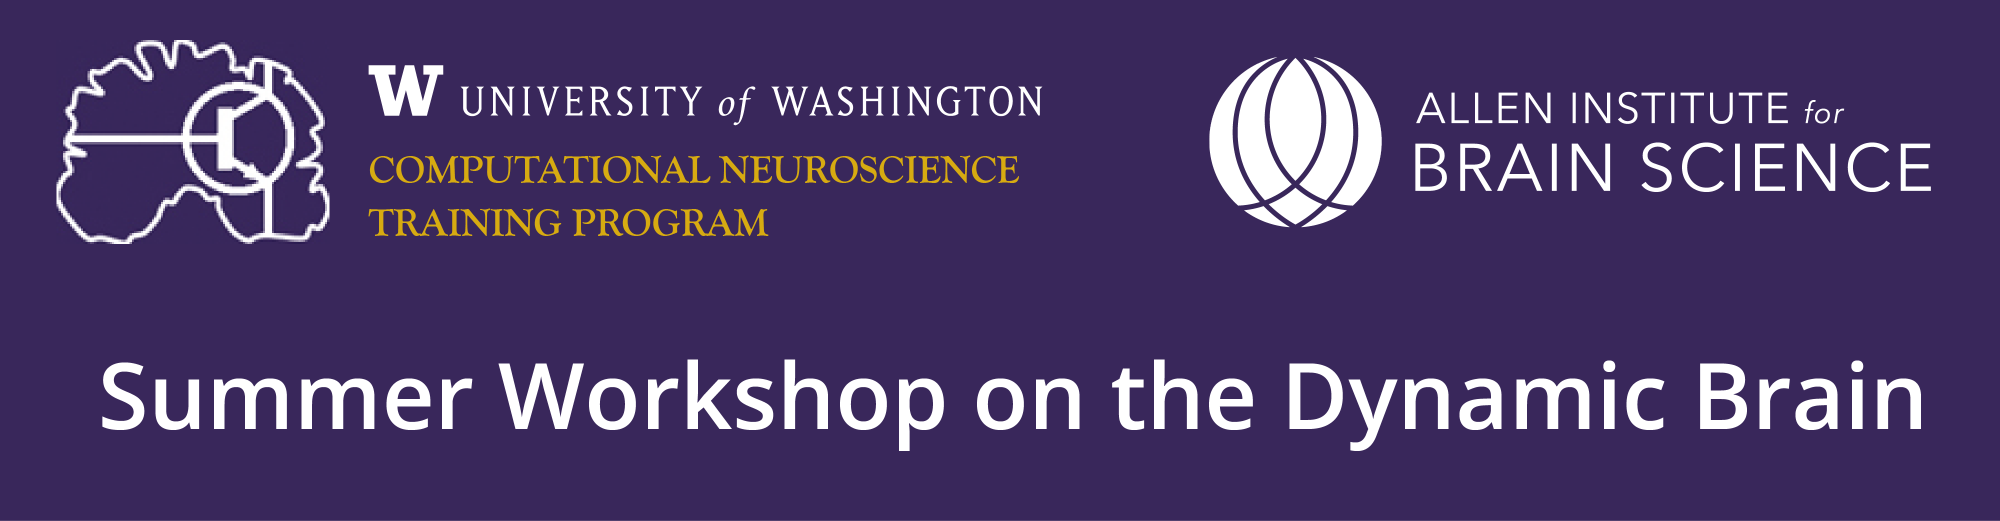 

<h1 align="center">Brain Observatory - Visual Behavior </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">August 24, 2021</h3> 


This notebook will introduce you to the Visual Behavior Brain Observatory dataset. This dataset uses 2-photon calcium imaging (also called optical physiology or ophys) to measure neural activity in mice performing a visual change detection task. One aim of this dataset is to ask: how is sensory coding influenced by expectation, engagement, and experience?

<h2>Image change detection task</h2>

The change detection task consists of a series of image presentations. Each image flash is 250ms followed by 500ms of gray screen. The task for the mouse is to lick in a 750ms response window following a change in image identity. On each trial, a change time is drawn from an exponential distribution between 2-8 seconds after trial start. Thus, each trial consists of multiple stimulus presentations. On go trials, a change in image identity occurs. On catch trials, no image change occurs (aka 'sham change'), and we measure false alarm rates in the same 750ms response window. Correct responses are rewarded and licks outside the response window abort the trial.

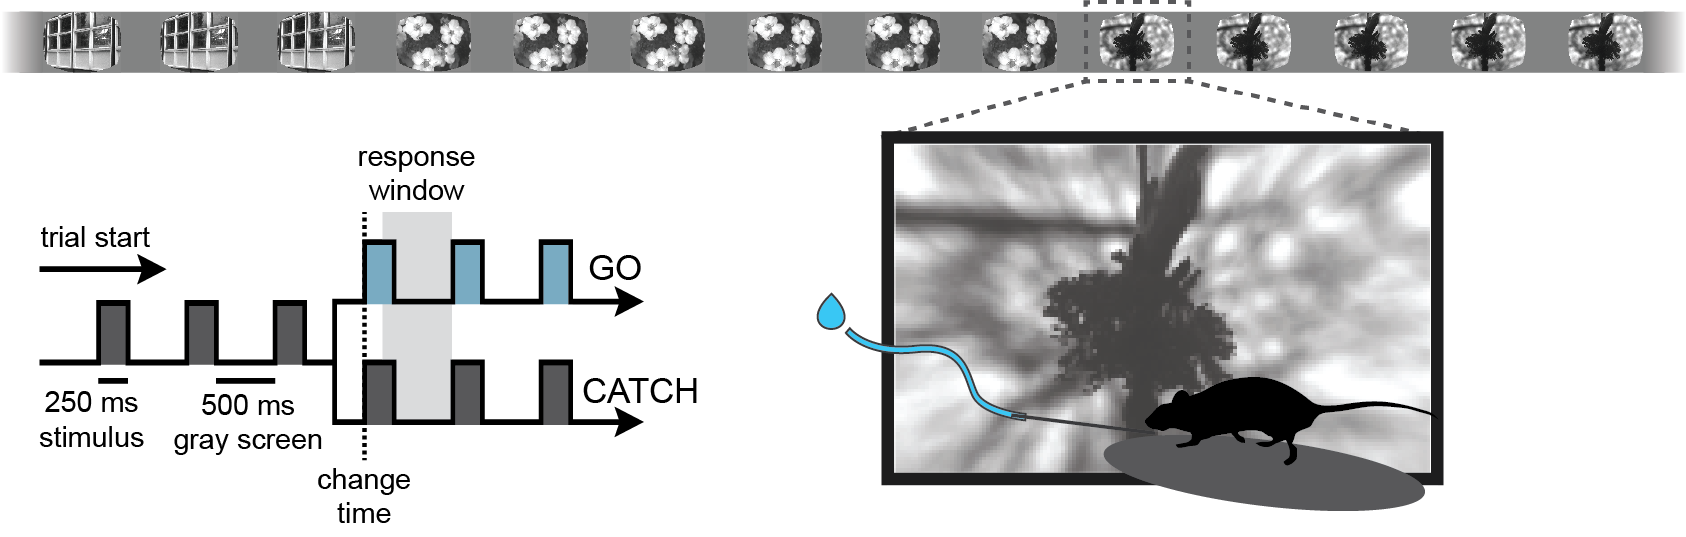

There are 8 natural scene images shown in each behavioral session. Mice learn the task first with gratings, then with a set of 8 natural scenes which become highly familiar with experience. During the imaging phase of the experiment, mice perform the task with the familiar image set, as well as another set of 8 images that are experienced for the first time under the microscope. This allows us to ask how training history and visual experience infuence sensory responses.

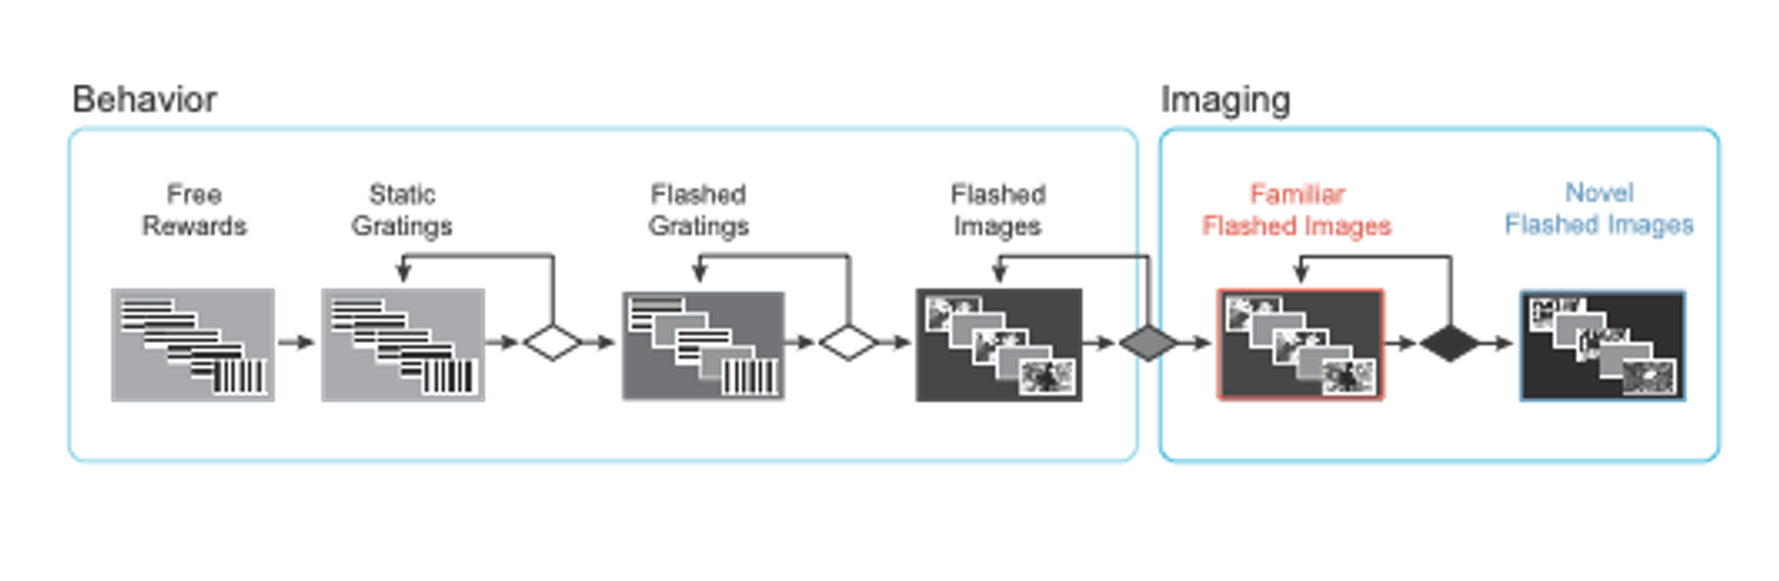

<h2>OPhys experimental design</h2>

There are 2 types of sessions during the imaging portion of the experiment - active behavior and passive viewing. During the passive viewing sessions, the task is run in open loop mode with the lick spout retracted, after the mouse has been given its daily allocation of water. This allows us to ask how representations differ when the mouse is actively engaged in the task and motivated to earn water rewards compared to when it is sated and not receiving reward feedback.

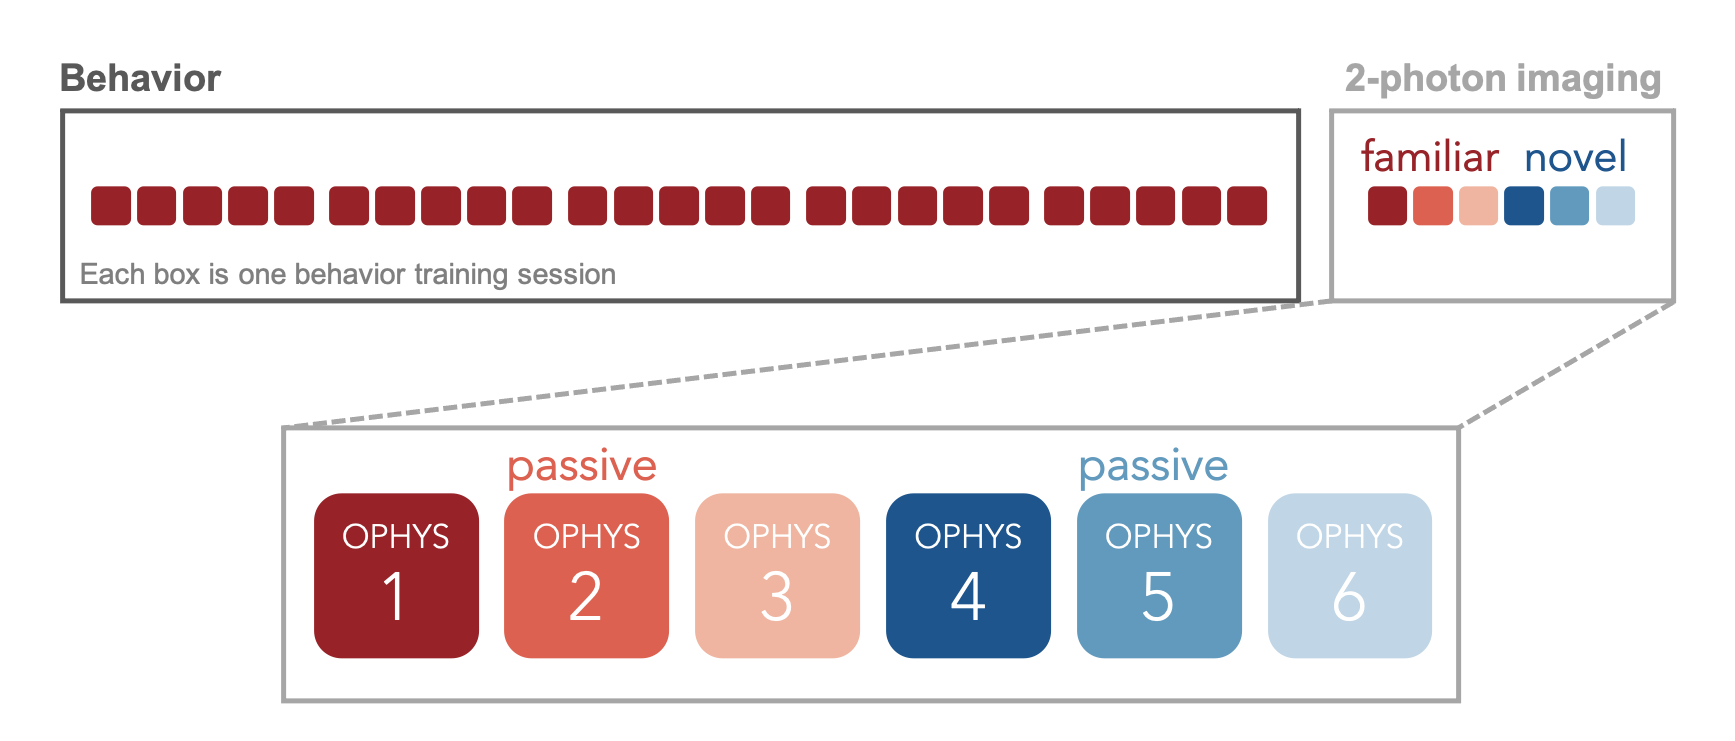

During imaging sessions, 5% of non-change image flashes are randomly omitted from the otherwise regular sequence of stimulus presentations. This allows us to ask whether expectation signals are present in the visual cortex. 

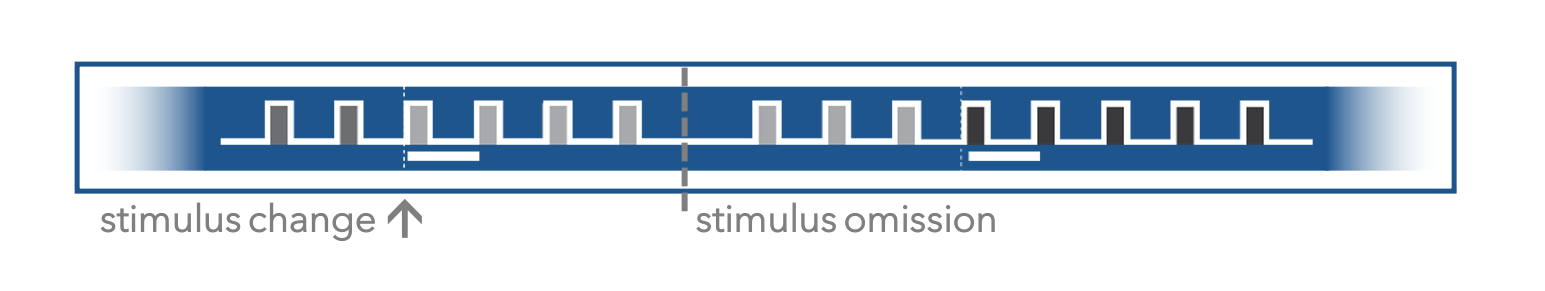

The dataset consists of recordings from excitatory (Slc17a7-IRES2-Cre;CaMK2-tTA;Ai93(GCaMP6f)), VIP inhibitory (Vip-IRES-Cre;Ai162(GCaMP6f)), and SST inhibitory (Sst-IRES-Cre;Ai162(GCaMP6f)) neurons in VISp, VISl, VISal, and VISam, sampled over multiple cortical depths. Some experiments were conducted using single-plane 2-photon imaging, while others were conducted using multi-plane 2-photon imaging to allow up to 8 imaging planes to be recorded simultaneously. 

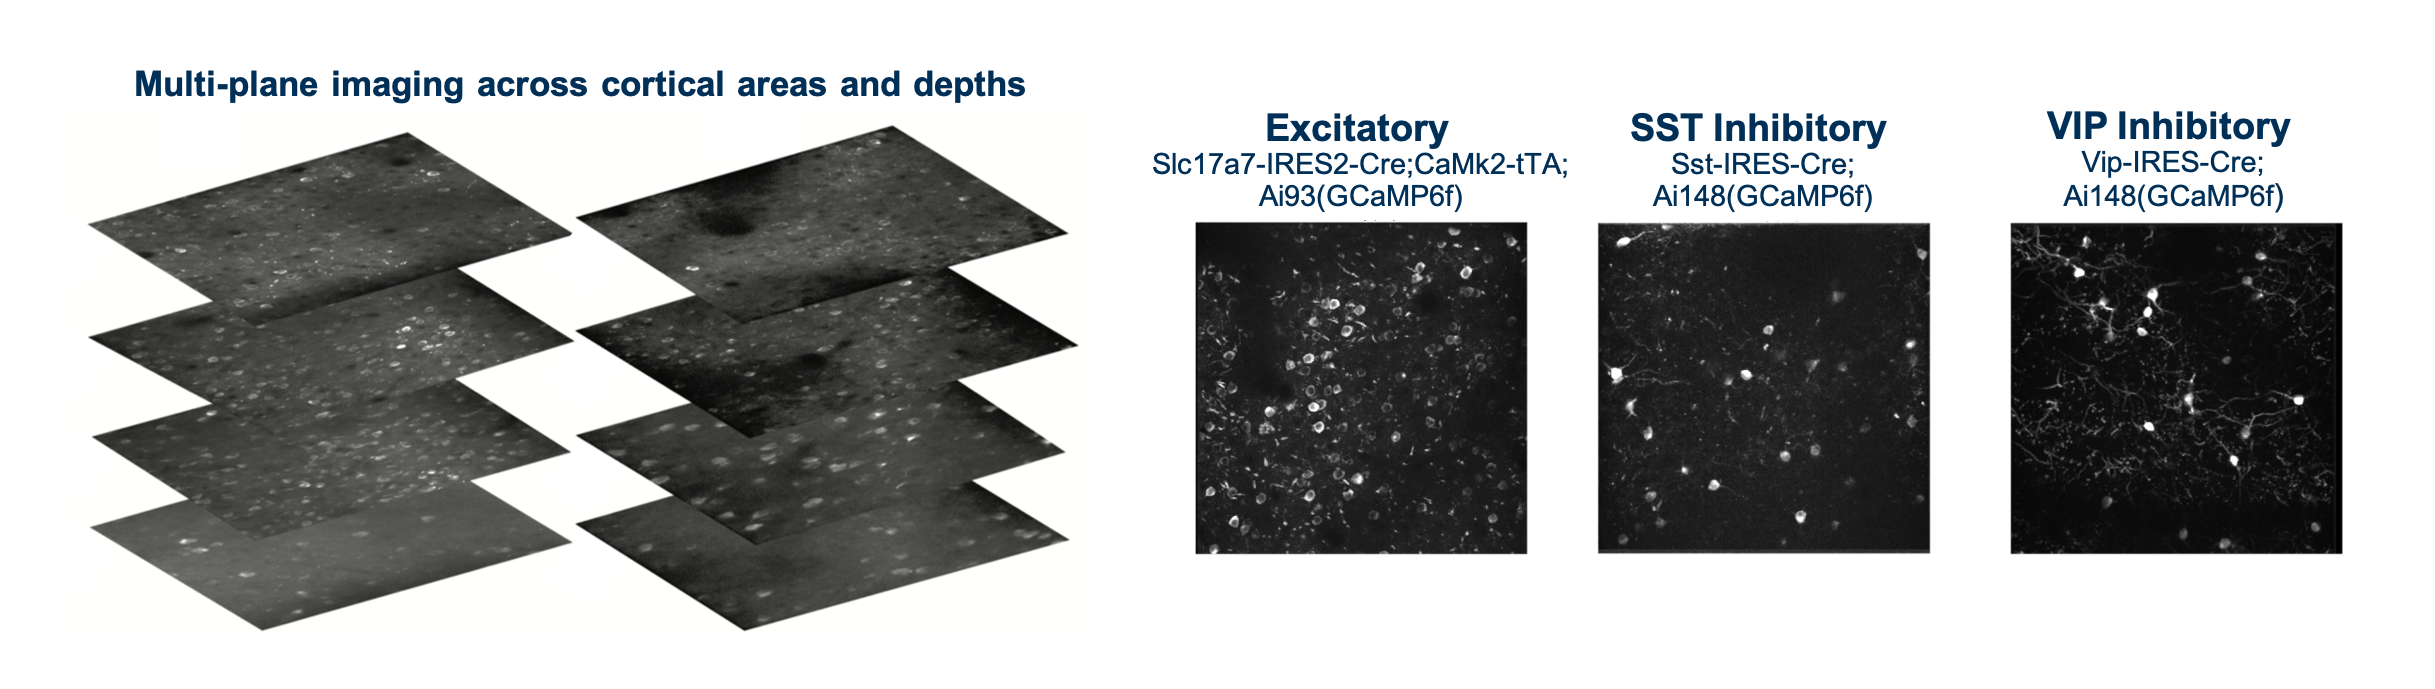

In this notebook, we will describe the core components of each experimental session and the tools for accessing and analyzing the data.

<h2>Dataset terminology</h2>
    
<p>The data collected in a single continuous recording is defined as a session. For single-plane imaging experiments, there is only one imaging plane (referred to as an experiment) per session. For multi-plane imaging experiments, there can be up to 8 imaging planes (aka 8 experiments) per session. Due to our strict QC process, not all multi-plane imaging sessions have exactly 8 experiments, as some imaging planes did not meet our data quality criteria. 
    
We aimed to track the activity of single neurons across the session types described above by targeting the same 
population of neurons over multiple recording sessions, with only one session recorded per day for a given mouse. The collection of imaging sessions for a given population of cells, belonging to a single imaging plane measured across days, is called a container. A container can include between 3 and 11 separate sessions for a given imaging plane. Mice imaged with the multi-plane 2-photon microscope can have multiple containers, one for each imaging plane recorded across multiple sessions. The session types available for a given container can vary, due to our selection criteria to ensure data quality.

Thus, each mouse can have one or more containers, each representing a unique imaging plane (experiment) that has been targeted across multiple recording sessions, under different behavioral and sensory conditions (session types).


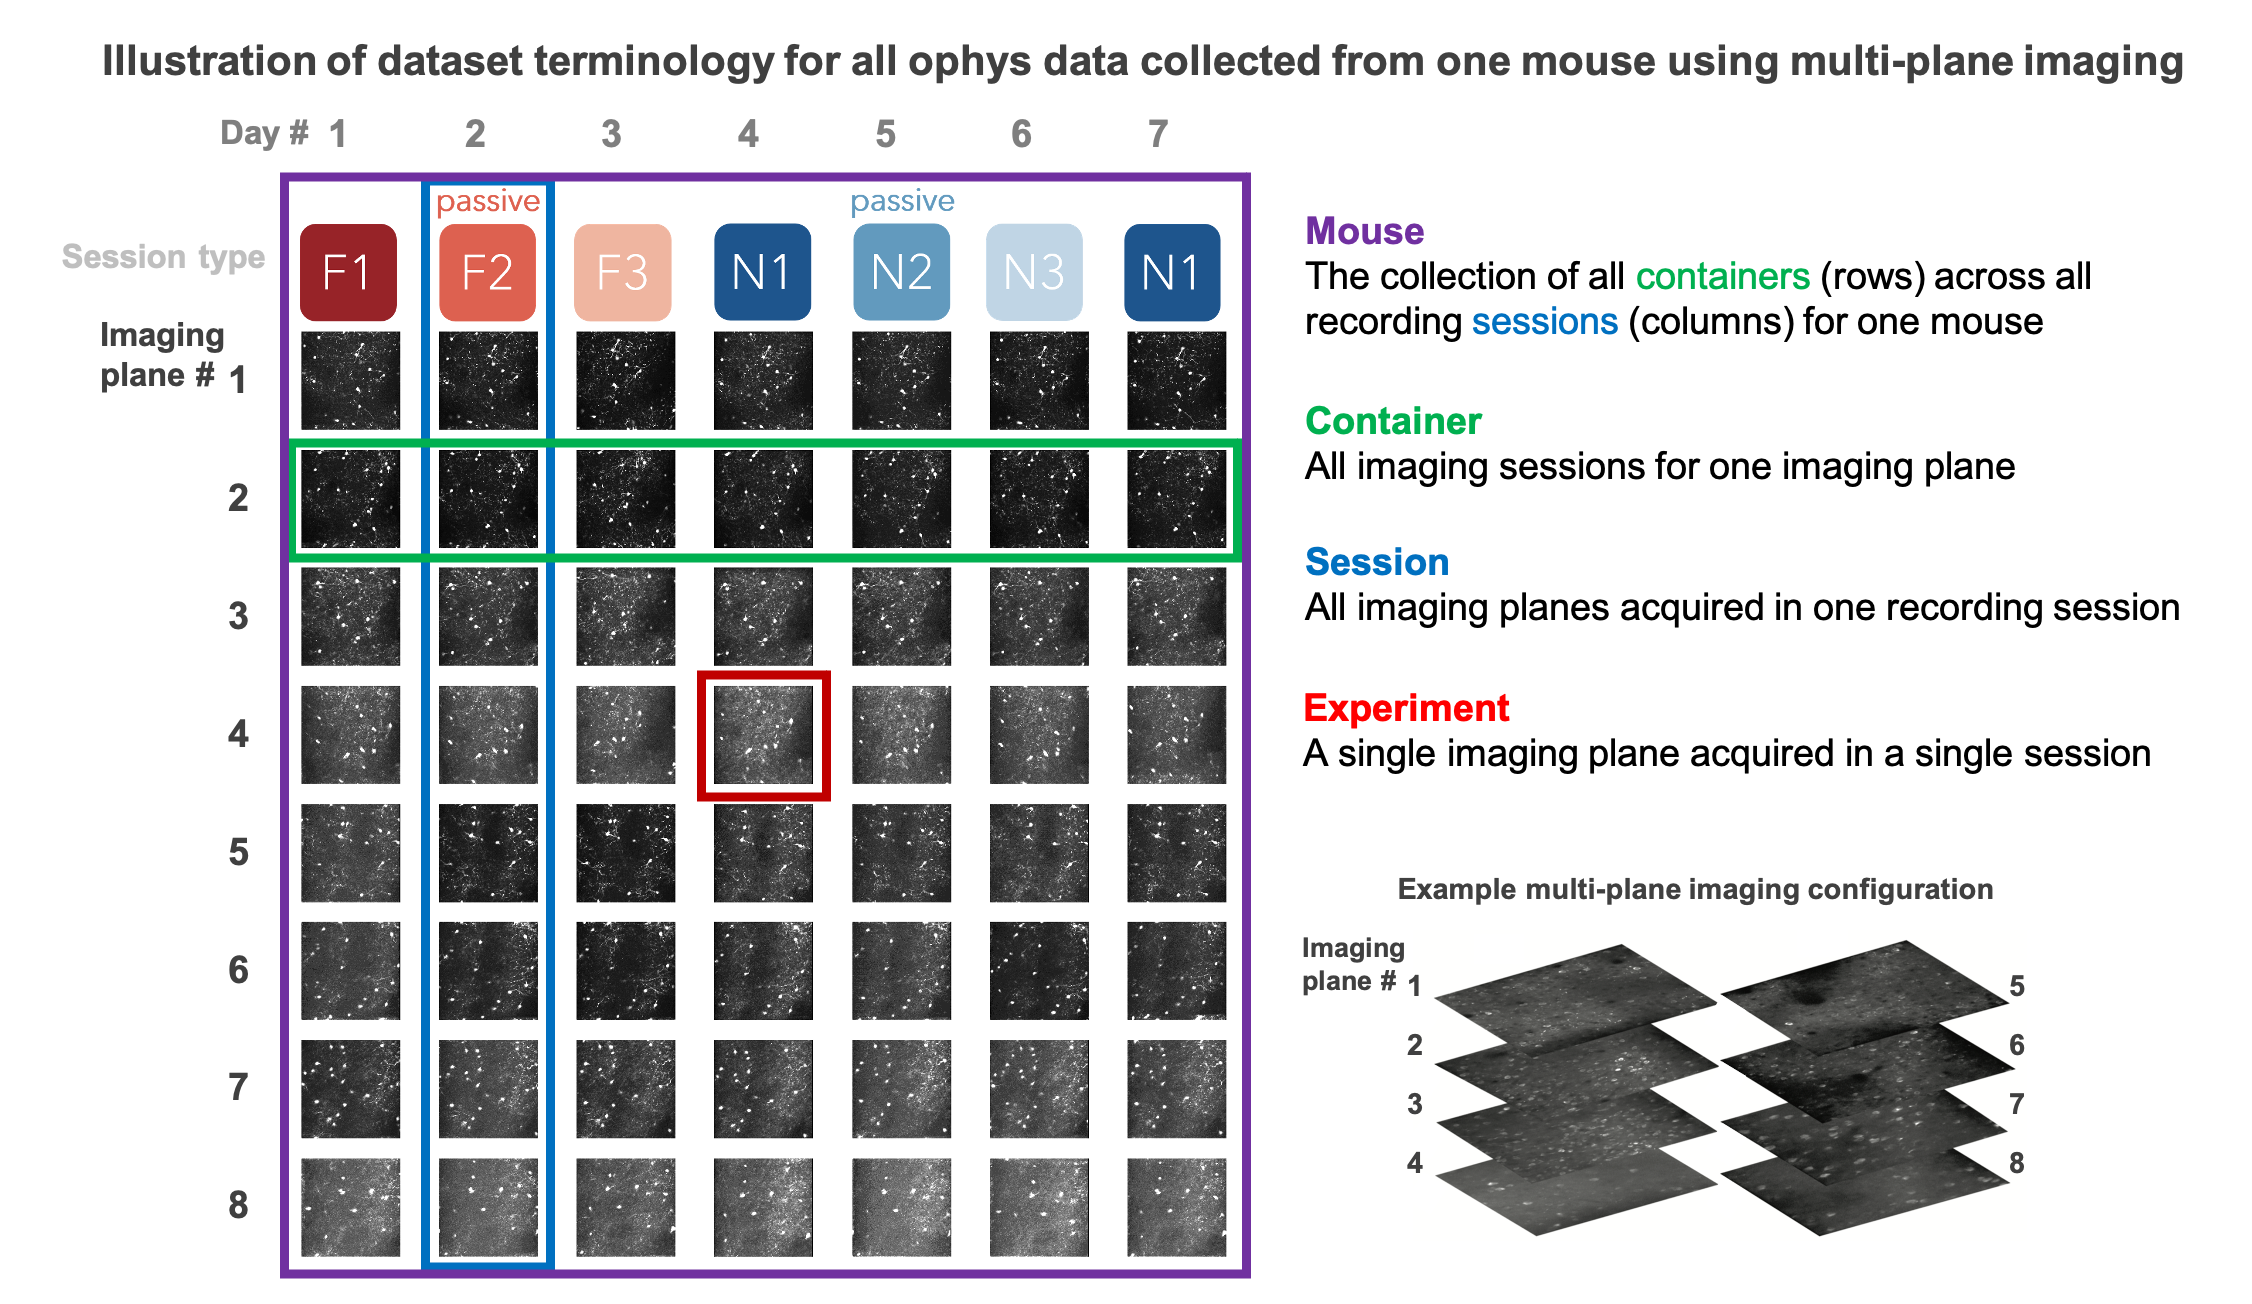

</div>

#### Imports

In [88]:
# STANDARD PYTHON PACKAGES

# computation & data manipulation packages
import os                   # operating system
import numpy as np          # math & numbers
import pandas as pd         # dataframe & tables

# plotting and data visualization packages
import matplotlib.pyplot as plt      # basic plotting
import seaborn as sns                # fancier plotting with many built in plotting functions

In [89]:
# ALLEN SDK
import allensdk
allensdk.__version__

'2.12.3'

In [90]:
# cache object for loading and interacting with the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

#### set notebook & plotting aesthetic 

In [91]:
# Jupyter notebook aesthetics
%matplotlib inline

# plotting aesthetics
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white');
sns.set_palette('deep');

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Dataset Cache Tables </h2>

<p>The first thing we will do is use the <code>allensdk</code> to load a cache for the visual behavior datasets, which contains 4 tables which provide a summary level view of all the currently released datasets. 

<p> Cache tables:

<ul><li> ophys_experiment_table
<li> ophys_session_table
<li> behavior_session_table
<li> ophys_cells_table
</ul>

<p>These tables contain roughly the same information but are organized differently. Each table is indexed by its corresponding id type (i.e. <code>ophys_experiment_table</code> uses <code>ophys_experiment_id</code> as its index.)

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>You can find a description of the metadata columns in each of these tables in the Visual Behavior cheat sheet or the SDK documentation provided here:</p> 
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf</a></p>  
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf</a></p>  
</div>

#### load the cache

In [92]:
import platform
platstring = platform.platform()

if ('amzn1' in platstring):
    # for AWS
    data_storage_directory = "/data/visual-behavior-ophys_data"
    # use local cache for AWS
    cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=data_storage_directory, use_static_cache=True)
else:  
    # for local drive, different operating systems
    if 'Darwin' in platstring:
        # OS X 
        data_root = "/Volumes/Brain2021/"
    elif 'Windows'  in platstring:
        # Windows (replace with the drive letter of USB drive)
        data_root = "E:/"
    else:
        # your own linux platform
        # EDIT location where you mounted hard drive
        data_root = "/media/$USERNAME/Brain2021/"
        data_root = "/run/media/tom.chartrand/Brain2021"
        
    # visual behavior cache directory
    cache_dir = manifest_path = os.path.join(data_root, "visual_behavior")
    # use from_s3_cache for loading from local directory
    cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:  Load and explore the cache tables </b></p>
    
<p>1) Load the <code>ophys_experiment_table</code>, <code>ophys_session_table</code>, and <code>behavior_session_table</code> using the <code>cache.get__fill in the blank__table() </code>.</p>
    
<p>2) List all columns of each table using pandas <code>.columns</code></p>
    
<p>3) Compare the column values across the different tables. What is in common between the different tables?</p>
    
<p> Hint: The cheat sheet is handy to help you quickly identify what columns are in what tables</p>
</div>

#### ophys_experiment_table

<p>The <code>ophys_experiment_table</code> contains metadata describing all 2-photon experiments, each conducted at a specific cortical location (<code>targeted_structure</code>) and <code>imaging_depth</code>. Each 2-photon field of view (imaging plane) was imaged over multiple sessions (each with a uique <code>ophys_session_id</code>), and will have a unique <code>ophys_experiment_id</code> in each session.</p>

The <code>ophys_container_id</code> is a unique identifier for a given imaging plane that was imaged over multiple sessions. Thus each <code>ophys_container_id</code> will correspond to multiple <code>ophys_experiment_ids</code>, all corresonding to the same 2-photon field of view imaged across multiple sessions. A given <code>ophys_experiment_id</code> will always be unique to a single ophys container. </p>

In [93]:
ophys_experiment_table = cache.get_ophys_experiment_table()
ophys_experiment_table.head()

equipment_name  \
ophys_experiment_id                  
951980486                   MESO.1   
951980473                   MESO.1   
951980481                   MESO.1   
951980471                   MESO.1   
951980475                   MESO.1   

                                                     full_genotype  mouse_id  \
ophys_experiment_id                                                            
951980486            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
951980473            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
951980481            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
951980471            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
951980475            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   

                                  reporter_line     driver_line sex  \
ophys_experiment_id                                                   
951980486            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
951980473            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
951980481            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
951980471            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
951980475            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   

                     age_in_days      cre_line indicator  session_number  ...  \
ophys_experiment_id                                                       ...   
951980486                  206.0  Sst-IRES-Cre   GCaMP6f             1.0  ...   
951980473                  206.0  Sst-IRES-Cre   GCaMP6f             1.0  ...   
951980481                  206.0  Sst-IRES-Cre   GCaMP6f             1.0  ...   
951980471                  206.0  Sst-IRES-Cre   GCaMP6f             1.0  ...   
951980475                  206.0  Sst-IRES-Cre   GCaMP6f             1.0  ...   

                     ophys_container_id              project_code  \
ophys_experiment_id                                                 
951980486                    1018028360  VisualBehaviorMultiscope   
951980473                    1018028345  VisualBehaviorMultiscope   
951980481                    1018028357  VisualBehaviorMultiscope   
951980471                    1018028342  VisualBehaviorMultiscope   
951980475                    1018028339  VisualBehaviorMultiscope   

                     imaging_depth  targeted_structure  \
ophys_experiment_id                                      
951980486                      300                VISl   
951980473                      225                VISp   
951980481                      225                VISl   
951980471                      150                VISp   
951980475                       75                VISp   

                            date_of_acquisition      session_type  \
ophys_experiment_id                                                 
951980486            2019-09-20 09:45:29.897856  OPHYS_1_images_A   
951980473            2019-09-20 09:45:29.897856  OPHYS_1_images_A   
951980481            2019-09-20 09:45:29.897856  OPHYS_1_images_A   
951980471            2019-09-20 09:45:29.897856  OPHYS_1_images_A   
951980475            2019-09-20 09:45:29.897856  OPHYS_1_images_A   

                    experience_level  passive image_set     file_id  
ophys_experiment_id                                                  
951980486                   Familiar    False         A  1085400869  
951980473                   Familiar    False         A  1085400919  
951980481                   Familiar    False         A  1085400972  
951980471                   Familiar    False         A  1085394308  
951980475                   Familiar    False         A  1085400920  

[5 rows x 25 columns]

In [94]:
# what are the columns of the ophys_experiment_table? 
ophys_experiment_table.columns

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'file_id'],
      dtype='object')

#### ophys_session_table



<p><code>ophys_session_table</code> contains the same information as the <code>ophys_experiment_table</code>, but organized by <code>ophys_session_id</code>. If Multiscope was used, one ophys session may contain up to 8 unique <code>ophys_experiment_ids</code>. Each <code>ophys_session_id</code> will also have a unique <code>behavior_session_id</code>.</p>


In [95]:
ophys_session_table = cache.get_ophys_session_table()
ophys_session_table.head()

equipment_name  \
ophys_session_id                  
951410079                MESO.1   
952430817                MESO.1   
954954402                MESO.1   
955775716                MESO.1   
957020350                MESO.1   

                                                  full_genotype  mouse_id  \
ophys_session_id                                                            
951410079         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
952430817         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
954954402         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
955775716         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
957020350         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   

                               reporter_line     driver_line sex  age_in_days  \
ophys_session_id                                                                
951410079         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        206.0   
952430817         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        209.0   
954954402         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        210.0   
955775716         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        212.0   
957020350         Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F        213.0   

                      cre_line indicator  session_number  \
ophys_session_id                                           
951410079         Sst-IRES-Cre   GCaMP6f             1.0   
952430817         Sst-IRES-Cre   GCaMP6f             2.0   
954954402         Sst-IRES-Cre   GCaMP6f             3.0   
955775716         Sst-IRES-Cre   GCaMP6f             3.0   
957020350         Sst-IRES-Cre   GCaMP6f             4.0   

                  prior_exposures_to_session_type  \
ophys_session_id                                    
951410079                                     0.0   
952430817                                     0.0   
954954402                                     0.0   
955775716                                     1.0   
957020350                                     0.0   

                  prior_exposures_to_image_set  prior_exposures_to_omissions  \
ophys_session_id                                                               
951410079                                 65.0                           0.0   
952430817                                 66.0                           1.0   
954954402                                 67.0                           2.0   
955775716                                 68.0                           3.0   
957020350                                  0.0                           4.0   

                  behavior_session_id  \
ophys_session_id                        
951410079                   951520319   
952430817                   952554548   
954954402                   953982960   
955775716                   956010809   
957020350                   957032492   

                                                ophys_experiment_id  \
ophys_session_id                                                      
951410079         [951980471, 951980473, 951980475, 951980479, 9...   
952430817              [953659743, 953659745, 953659749, 953659752]   
954954402         [958527464, 958527471, 958527474, 958527479, 9...   
955775716                         [956941841, 956941844, 956941846]   
957020350         [957759562, 957759564, 957759566, 957759570, 9...   

                                                 ophys_container_id  \
ophys_session_id                                                      
951410079         [1018028360, 1018028345, 1018028357, 101802834...   
952430817          [1018028357, 1018028345, 1018028339, 1018028354]   
954954402         [1018028360, 1018028342, 1018028357, 101802835...   
955775716                      [1018028342, 1018028339, 1018028345]   
957020350         [1018028354, 1018028345, 1018028360, 101802834...   

                         

In [96]:
# what are the columns of the ophys_session_table? 
ophys_session_table.columns

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'behavior_session_id', 'ophys_experiment_id', 'ophys_container_id',
       'project_code', 'date_of_acquisition', 'session_type'],
      dtype='object')

#### behavior_session_table

<p>The <code>behavior_session_table</code> contains metadata describing all behavioral sessions, during training and during 2-photon imaging. This can be used to track the behavioral training history of each mouse. You can use the <code>session_type</code> column to determine whether a session was during training or ophys</p>
    
<p></p>    
<p>Due to our ophys Quality Control process, some ophys sessions, or specific ophys experiments (imaging planes) within a session may not be released. However, behavior data is available for all sessions, regardless of whether there was ophys data or not. Behavior sessions that have an <code>ophys_session_id</code> have released ophys_data. 
    

In [97]:
behavior_session_table = cache.get_behavior_session_table()
behavior_session_table.head()

equipment_name  \
behavior_session_id                  
870987812               BEH.D-Box1   
872953842               BEH.D-Box1   
873774125               BEH.D-Box1   
874790261               BEH.D-Box1   
875207834               BEH.D-Box1   

                                                     full_genotype  mouse_id  \
behavior_session_id                                                            
870987812            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
872953842            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
873774125            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
874790261            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   
875207834            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    457841   

                                  reporter_line     driver_line sex  \
behavior_session_id                                                   
870987812            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
872953842            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
873774125            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
874790261            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   
875207834            Ai148(TIT2L-GC6f-ICL-tTA2)  [Sst-IRES-Cre]   F   

                     age_in_days      cre_line indicator  session_number  \
behavior_session_id                                                        
870987812                   80.0  Sst-IRES-Cre   GCaMP6f             NaN   
872953842                   84.0  Sst-IRES-Cre   GCaMP6f             NaN   
873774125                   85.0  Sst-IRES-Cre   GCaMP6f             NaN   
874790261                   86.0  Sst-IRES-Cre   GCaMP6f             NaN   
875207834                   87.0  Sst-IRES-Cre   GCaMP6f             NaN   

                     prior_exposures_to_session_type  \
behavior_session_id                                    
870987812                                        0.0   
872953842                                        0.0   
873774125                                        1.0   
874790261                                        2.0   
875207834                                        3.0   

                     prior_exposures_to_image_set  \
behavior_session_id                                 
870987812                                     NaN   
872953842                                     NaN   
873774125                                     NaN   
874790261                                     NaN   
875207834                                     NaN   

                     prior_exposures_to_omissions  ophys_session_id  \
behavior_session_id                                                   
870987812                                     0.0               NaN   
872953842                                     0.0               NaN   
873774125                                     0.0               NaN   
874790261                                     0.0               NaN   
875207834                                     0.0               NaN   

                    ophys_experiment_id ophys_container_id project_code  \
behavior_session_id                                                       
870987812                           NaN                NaN          NaN   
872953842                           NaN                NaN          NaN   
873774125                           NaN                NaN          NaN   
874790261                           NaN                NaN          NaN   
875207834                           NaN                NaN          NaN   

                         date_of_acquisition  \
behavior_session_id                            
870987812            2019-05-17 14:46:33.550   
872953842            2019-05-21 13:22:20.613   
873774125            2019-05-22 13:19:52.005   
874790261            2019-05-23 13:40:31.405   
875207834            2019-05-24 11:06:39.332   

                                   

In [98]:
# what are the columns of the behavior_session_table?
behavior_session_table.columns

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'ophys_experiment_id', 'ophys_container_id',
       'project_code', 'date_of_acquisition', 'session_type', 'file_id'],
      dtype='object')

#### ophys_cells_table

<p>The <code>ophys_cells_table</code> contains the unique IDs of all cells recorded across all experiments. You can use this table to determine which ophys experiments a given cell was matched in. 
    
<p>The <code>cell_roi_id</code> index contains a unique roi ID for each cell segmented in each ophys experiment.</p>
<p>The <code>cell_specimen_id</code> is a unique ID for each cell that is shared across all ophys experiments  that cell was recorded in. </p>
<p>Thus, a cell that was imaged in more than one experiment has multiple <code>cell_roi_ids</code> but one <code>cell_specimen_id</code>.</p>

In [99]:
ophys_cells_table = cache.get_ophys_cells_table()
ophys_cells_table.head()

cell_specimen_id  ophys_experiment_id
cell_roi_id                                       
1080884343         1086496928            775614751
1080884173         1086496914            775614751
1080883843         1086496838            775614751
1080886674         1086491756            775614751
1080885658         1086491699            775614751

In [100]:
# What are the columns of the ophys_cells_table? What could this table be used for? 
ophys_cells_table.columns

Index(['cell_specimen_id', 'ophys_experiment_id'], dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task 1.2 Exploring and filtering the <code>ophys_experiment_table</code> </b></p>
    
<p>Using the <code>ophys_experiment_table</code>, do the following: </p>
 
<p>1) List all unique entries for the<code>cre_line</code> column and the <code>full_genotype</code> column using the pandas <code>.unique()</code> method. Are they the same length? What is different about them? </p>

<p>2) List all unique entries for the<code>project_code</code> column </p>
    
<p>3) Select a specific <code>project_code</code>, filter the table by that value, and assign it to a new variable</p>
    
<p>4) In your filtered table, list all unique entries for the<code>targeted_structure</code> column </p>

<p>5) In your filtered table, list all unique entries for the<code>session_type</code> column </p>

<p>6) Repeat for a different <code>project_code</code>. What are the differences?  </p>
</div>

In [101]:
# print out the unique values of cre_line in this table
print('available cre lines include:', ophys_experiment_table.cre_line.unique())

available cre lines include: ['Sst-IRES-Cre' 'Vip-IRES-Cre' 'Slc17a7-IRES2-Cre']


In [102]:
# print out the unique values of full_genotype in this table
print('available full_genotypes include:', ophys_experiment_table.full_genotype.unique())

available full_genotypes include: ['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt']


In [103]:
# print out the unique values of project_code in this table
print('available project codes include:', ophys_experiment_table.project_code.unique())

available project codes include: ['VisualBehaviorMultiscope' 'VisualBehaviorTask1B' 'VisualBehavior'
 'VisualBehaviorMultiscope4areasx2d']


In [104]:
# filter to select one project code
selected_project_code = 'VisualBehaviorMultiscope'
project_experiment_table = ophys_experiment_table[ophys_experiment_table.project_code==selected_project_code]

In [105]:
# print out what is available for targeted_structure and session_type
print('available areas include:', project_experiment_table.targeted_structure.unique())
print('available session types include:', project_experiment_table.session_type.unique())

available areas include: ['VISl' 'VISp']
available session types include: ['OPHYS_1_images_A' 'OPHYS_2_images_A_passive' 'OPHYS_3_images_A'
 'OPHYS_4_images_B' 'OPHYS_5_images_B_passive' 'OPHYS_6_images_B'
 'OPHYS_2_images_B_passive']


In [106]:
# try for another project code - what is different?
selected_project_code = 'VisualBehaviorMultiscope4areasx2d'
project_experiment_table = ophys_experiment_table[ophys_experiment_table.project_code==selected_project_code]
print('for project_code:', selected_project_code)
print('available areas include:', project_experiment_table.targeted_structure.unique())
print('available session types include:', project_experiment_table.session_type.unique())

for project_code: VisualBehaviorMultiscope4areasx2d
available areas include: ['VISal' 'VISp' 'VISl' 'VISam']
available session types include: ['OPHYS_1_images_G' 'OPHYS_3_images_G' 'OPHYS_2_images_G_passive'
 'OPHYS_4_images_H' 'OPHYS_5_images_H_passive' 'OPHYS_6_images_H']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task 1.3 Exploring and filtering the <code>behavior_session_table</code></b></p>
    
<p>Using the <code>behavior_session_table</code>, do the following:</b></p>
 
<p>1) Count the total number of unique mice available using the <code>mouse_id</code> column and pandas <code>.unique()</code> method</p>

<p>2) Select a <code>mouse_id</code> at a random using pandas <code>.sample()</code> and then filter the table based on that <code>mouse_id</code> </p>

<p>3) List all the values of <code>session_type</code> for that mouse</p>
    
<p>4) Behavior sessions that also have ophys data have an <code>ophys_session_id</code>. Use the pandas method <code>.isnull()</code> to determine how many sessions have an <code>ophys_session_id</code> and which do not. </p>

<p> Hint: the pandas cheat sheet provides examples of each of these methods. You can also find more documentation here: 

__[Pandas documentation ](https://pandas.pydata.org/docs/reference/index.html)__ </p>

</div>

In [107]:
# how many mice? 
print('there are', len(behavior_session_table.mouse_id.unique()), 'mice')

there are 107 mice


In [108]:
# get a random mouse id
random_index = behavior_session_table.sample(1).index[0]
random_mouse_id = behavior_session_table['mouse_id'][random_index]

# filter the behavior table & display it
mouse_behavior_table = behavior_session_table[behavior_session_table["mouse_id"]==random_mouse_id]
mouse_behavior_table.head()

equipment_name  \
behavior_session_id                  
858098096               BEH.B-Box1   
859064345               BEH.B-Box1   
859735301               BEH.B-Box1   
860650174               BEH.B-Box1   
861785387               BEH.B-Box1   

                                                     full_genotype  mouse_id  \
behavior_session_id                                                            
858098096            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    453988   
859064345            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    453988   
859735301            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    453988   
860650174            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    453988   
861785387            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    453988   

                                  reporter_line     driver_line sex  \
behavior_session_id                                                   
858098096            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   
859064345            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   
859735301            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   
860650174            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   
861785387            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   

                     age_in_days      cre_line indicator  session_number  \
behavior_session_id                                                        
858098096                   77.0  Vip-IRES-Cre   GCaMP6f             NaN   
859064345                   80.0  Vip-IRES-Cre   GCaMP6f             NaN   
859735301                   81.0  Vip-IRES-Cre   GCaMP6f             NaN   
860650174                   82.0  Vip-IRES-Cre   GCaMP6f             NaN   
861785387                   83.0  Vip-IRES-Cre   GCaMP6f             NaN   

                     prior_exposures_to_session_type  \
behavior_session_id                                    
858098096                                        0.0   
859064345                                        0.0   
859735301                                        1.0   
860650174                                        2.0   
861785387                                        3.0   

                     prior_exposures_to_image_set  \
behavior_session_id                                 
858098096                                     NaN   
859064345                                     NaN   
859735301                                     NaN   
860650174                                     NaN   
861785387                                     NaN   

                     prior_exposures_to_omissions  ophys_session_id  \
behavior_session_id                                                   
858098096                                     0.0               NaN   
859064345                                     0.0               NaN   
859735301                                     0.0               NaN   
860650174                                     0.0               NaN   
861785387                                     0.0               NaN   

                    ophys_experiment_id ophys_container_id project_code  \
behavior_session_id                                                       
858098096                           NaN                NaN          NaN   
859064345                           NaN                NaN          NaN   
859735301                           NaN                NaN          NaN   
860650174                           NaN                NaN          NaN   
861785387                           NaN                NaN          NaN   

                         date_of_acquisition  \
behavior_session_id                            
858098096            2019-04-26 11:17:42.498   
859064345            2019-04-29 14:02:46.682   
859735301            2019-04-30 12:45:15.762   
860650174            2019-05-01 11:39:00.517   
861785387            2019-05-02 13:33:51.108   

                                   

In [109]:
# what are the session_types available for this mouse? 
mouse_behavior_table.session_type.unique()

array(['TRAINING_0_gratings_autorewards_15min', 'TRAINING_1_gratings',
       'TRAINING_2_gratings_flashed', 'TRAINING_3_images_A_10uL_reward',
       'TRAINING_4_images_A_training', 'TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_ready',
       'TRAINING_5_images_A_handoff_lapsed',
       'OPHYS_0_images_A_habituation', 'OPHYS_1_images_A',
       'OPHYS_2_images_B_passive', 'OPHYS_3_images_B', 'OPHYS_4_images_B',
       'OPHYS_5_images_B_passive', 'OPHYS_6_images_B', 'OPHYS_3_images_A',
       'OPHYS_2_images_A_passive'], dtype=object)

In [110]:
# how many sessions have ophys data? 
sessions_with_ophys = mouse_behavior_table[mouse_behavior_table.ophys_session_id.isnull()==False]
print(len(sessions_with_ophys), 'sessions have ophys data')

7 sessions have ophys data


In [111]:
# how may sessions do not have ophys data? 
sessions_without_ophys = mouse_behavior_table[mouse_behavior_table.ophys_session_id.isnull()==True]
print(len(sessions_without_ophys), 'sessions do not have ophys data')

79 sessions do not have ophys data


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task 1.4 Exploring the <code>ophys_cells_table</code></b></p>
 
<p>1) Select a specific <code>cell_specimen_id</code> and filter the <code>ophys_cells_table</code> to get all the <code>ophys_experiment_id</code>s a cell was matched across. </p>
    
<p>2) Try again for a few more random <code>cell_specimen_id</code>s. How many <code>ophys_experiment_id</code>s, aka unique imaging planes, do they have? Find a <code>cell_specimen_id</code> that was matched in more than 4 experiments.</p> 
    
<p>3) Add experiment metadata to the <code>ophys_cells_table</code> using the pandas <code>.join()</code> method to join the <code>ophys_experiment_table</code> with the <code>ophys_cells_table</code>, joining on <code>ophys_experiment_id</code></p>
    
<p>4) What are the <code>session_type</code>s that your <code>cell_specimen_id</code> was present in? Were any <code>session_type</code>s repeated more than once? </p>
    

</div>

In [112]:
# load ophys_cells_table from the cache
ophys_cell_table = cache.get_ophys_cells_table()
ophys_cell_table.head()

cell_specimen_id  ophys_experiment_id
cell_roi_id                                       
1080884343         1086496928            775614751
1080884173         1086496914            775614751
1080883843         1086496838            775614751
1080886674         1086491756            775614751
1080885658         1086491699            775614751

In [113]:
# get a random cell_specimen_id
random_index = ophys_cell_table.sample(n = 1).index[0]
random_cell_specimen_id = ophys_cell_table["cell_specimen_id"][random_index]

# filter the cell table to get all occurances of specific cell_specimen_id
ophys_cell_table[ophys_cell_table["cell_specimen_id"] == random_cell_specimen_id]

cell_specimen_id  ophys_experiment_id
cell_roi_id                                       
1080659389         1086563350            992084627
1080665776         1086563350            993619368
1080641122         1086563350            993891845
1080671052         1086563350            994082676

In [114]:
# try again for another cell_specimen_id. How many experiments is it matched in? 


In [115]:
# join ophys_cells_table with ophys_experiment_table
ophys_cell_table = ophys_cell_table.join(ophys_experiment_table, on='ophys_experiment_id')
ophys_cell_table.head()

cell_specimen_id  ophys_experiment_id equipment_name  \
cell_roi_id                                                         
1080884343         1086496928            775614751        CAM2P.5   
1080884173         1086496914            775614751        CAM2P.5   
1080883843         1086496838            775614751        CAM2P.5   
1080886674         1086491756            775614751        CAM2P.5   
1080885658         1086491699            775614751        CAM2P.5   

                                                 full_genotype  mouse_id  \
cell_roi_id                                                                
1080884343   Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...  403491.0   
1080884173   Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...  403491.0   
1080883843   Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...  403491.0   
1080886674   Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...  403491.0   
1080885658   Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...  403491.0   

                  reporter_line                      driver_line sex  \
cell_roi_id                                                            
1080884343   Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   
1080884173   Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   
1080883843   Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   
1080886674   Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   
1080885658   Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   

             age_in_days           cre_line  ... ophys_container_id  \
cell_roi_id                                  ...                      
1080884343         160.0  Slc17a7-IRES2-Cre  ...        782536745.0   
1080884173         160.0  Slc17a7-IRES2-Cre  ...        782536745.0   
1080883843         160.0  Slc17a7-IRES2-Cre  ...        782536745.0   
1080886674         160.0  Slc17a7-IRES2-Cre  ...        782536745.0   
1080885658         160.0  Slc17a7-IRES2-Cre  ...        782536745.0   

               project_code  imaging_depth  targeted_structure  \
cell_roi_id                                                      
1080884343   VisualBehavior          375.0                VISp   
1080884173   VisualBehavior          375.0                VISp   
1080883843   VisualBehavior          375.0                VISp   
1080886674   VisualBehavior          375.0                VISp   
1080885658   VisualBehavior          375.0                VISp   

                    date_of_acquisition      session_type  experience_level  \
cell_roi_id                                                                   
1080884343   2018-11-08 18:38:05.000000  OPHYS_1_images_A          Familiar   
1080884173   2018-11-08 18:38:05.000000  OPHYS_1_images_A          Familiar   
1080883843   2018-11-08 18:38:05.000000  OPHYS_1_images_A          Familiar   
1080886674   2018-11-08 18:38:05.000000  OPHYS_1_images_A          Familiar   
1080885658   2018-11-08 18:38:05.000000  OPHYS_1_images_A          Familiar   

             passive image_set      file_id  
cell_roi_id                                  
1080884343     False         A  945253901.0  
1080884173     False         A  945253901.0  
1080883843     False         A  945253901.0  
1080886674     False         A  945253901.0  
1080885658     False         A  945253901.0  

[5 rows x 27 columns]

In [116]:
# what session_types was your cell_specimen_id matched in? 
ophys_cell_table[ophys_cell_table["cell_specimen_id"] == random_cell_specimen_id].session_type.values

array(['OPHYS_1_images_A', 'OPHYS_2_images_A_passive', 'OPHYS_4_images_B',
       'OPHYS_4_images_B'], dtype=object)


<p>Because each cell is associated with a single field of view (imaging plane), each <code>cell_specimen_id</code> will belong to a single <code>ophys_container_id</code>, which links all <code>ophys_experiment_ids</code> for a given imaging plane across sessions. </p>

<p>If a cell was not active in a particular session and was not detected by our segmentation algorithm, which relies on cell activity to identify ROIs, then that cell's <code>cell_specimen_id</code> will not be present in that session. In other words, not all cells are present in all sessions for a given mouse.</p>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.5:  What is in an ophys container? </b></p>

<p>The Ophys Experiment Container describes a set of imaging sessions recorded from the same 2-photon field of view, targeting the same population of neurons. All the sessions in an ophys container have a common <code>ophys_container_id</code>,  but a unique <code>ophys_experiment_id</code> within each session.</p>

<p> Using the <code>ophys_experiment_table</code> do the following:</p>

<p> 1) Get the <code>ophys_container_id</code> for one <code>ophys_experiment_id</code> and find out what other sessions were recorded from that same field of view. </p>
    
<p> 2) Use pandas <code>.groupby()</code> and <code>.get_group()</code> to see what other experiments are in that specific container</p>
    
<p> 3) Get the number of experiments associated with each container by using  <code>.groupby</code> and <code>.size()</code>. Do all containers have the same number of experiments associated with them? </p>

</div>

In [117]:
# get the container ID for this experiment
random_ophys_exp_id = ophys_experiment_table.sample(1).index[0]

container_id = ophys_experiment_table['ophys_container_id'][random_ophys_exp_id]

In [118]:
# what other ophys experiments are in this container?
ophys_experiment_table.groupby('ophys_container_id').get_group(container_id)

equipment_name  \
ophys_experiment_id                  
875564401                   MESO.1   
872499152                   MESO.1   
873970527                   MESO.1   
877669817                   MESO.1   
877057344                   MESO.1   

                                                     full_genotype  mouse_id  \
ophys_experiment_id                                                            
875564401            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    449653   
872499152            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    449653   
873970527            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    449653   
877669817            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    449653   
877057344            Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    449653   

                                  reporter_line     driver_line sex  \
ophys_experiment_id                                                   
875564401            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   
872499152            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   
873970527            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   
877669817            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   
877057344            Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   M   

                     age_in_days      cre_line indicator  session_number  ...  \
ophys_experiment_id                                                       ...   
875564401                  119.0  Vip-IRES-Cre   GCaMP6f             2.0  ...   
872499152                  122.0  Vip-IRES-Cre   GCaMP6f             3.0  ...   
873970527                  123.0  Vip-IRES-Cre   GCaMP6f             1.0  ...   
877669817                  124.0  Vip-IRES-Cre   GCaMP6f             4.0  ...   
877057344                  130.0  Vip-IRES-Cre   GCaMP6f             4.0  ...   

                     ophys_container_id              project_code  \
ophys_experiment_id                                                 
875564401                    1018027593  VisualBehaviorMultiscope   
872499152                    1018027593  VisualBehaviorMultiscope   
873970527                    1018027593  VisualBehaviorMultiscope   
877669817                    1018027593  VisualBehaviorMultiscope   
877057344                    1018027593  VisualBehaviorMultiscope   

                     imaging_depth  targeted_structure  \
ophys_experiment_id                                      
875564401                       83                VISp   
872499152                       79                VISp   
873970527                       81                VISp   
877669817                       75                VISp   
877057344                       81                VISp   

                            date_of_acquisition              session_type  \
ophys_experiment_id                                                         
875564401            2019-05-17 08:56:51.000000  OPHYS_2_images_A_passive   
872499152            2019-05-20 08:53:27.000000          OPHYS_3_images_A   
873970527            2019-05-21 09:22:38.000000          OPHYS_1_images_A   
877669817            2019-05-22 08:08:26.000000          OPHYS_4_images_B   
877057344            2019-05-28 09:13:07.737028          OPHYS_4_images_B   

                    experience_level  passive image_set     file_id  
ophys_experiment_id                                                  
875564401                   Familiar     True         A  1085397857  
872499152                   Familiar    False         A  1085397394  
873970527                   Familiar    False         A  1085396572  
877669817                    Novel 1    False         B  1085396682  
877057344                   Novel >1    False         B  1085393650  

[5 rows x 25 columns]

In [119]:
# Get number of sessions in each container using .groupby()
ophys_experiment_table.groupby('ophys_container_id').size()

ophys_container_id
782536745     4
791352433     6
803516615     6
803517529     5
803589437     6
             ..
1115959878    5
1115960060    6
1116425939    5
1116427949    4
1116527497    5
Length: 326, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Reminder:</b> You can find a description of the metadata columns for all cache tables in the Visual Behavior cheat sheet or the SDK documentation provided here:</p>
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf</a></p>  
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf</a></p>  
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Dataset Object Types </h2>

Visual Behavior has 2 types of dataset objects:
<ul><li> Behavior Session Dataset
<li> Behavior Ophys Experiment Dataset
</ul>

<p><b>Behavior Session Dataset:</b> contains the data streams associated with the behavior of the mouse and its task performance. For behavior sessions, all data is sampled at 60Hz (the stimulus frame rate), and are referenced relative to the start of the stimulus.</p>
<p><b>Behavior Ophys Experiment Dataset:</b> contains 2-photon optical physiology data for all cells recorded in a single imaging plane in a single session, in addition to all behavioral data streams available in the Behavior Session, as well as pupil tracking information. Ophys experiments have data streams sampled at different rates (ophys at 11Hz or 30Hz, stimulus and behavior at 60Hz, pupil tracking at 30Hz), aligned to a common time clock. </p>

<p>During the training of the mice, only behavior data was collected, and thus, training sessions only have Behavior Session datasets. However, a behavior + optical physiology session has both a Behavior Session dataset and an Ophys Experiment dataset. Optical physiology experiments that did not pass ophys QC still have a Behavior Session dataset so that animal performance can be tracked even in the absence of ophys data.


 __[Documentation for Visual Behavior Datasets](https://alleninstitute.sharepoint.com/:w:/r/sites/VisualBehaviorAIBS/_layouts/15/guestaccess.aspx?e=Jm7GmA&share=EUkWXB9X8wZKleIGtsviscMBTgesWXsrHESs84Ye9FvqzQ)__</p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.1 Loading a Behavior Session dataset</b></p>
    
<p> 1) Load a Behavior Session Dataset for some <code>behavior_session_id</code> the cache method <code>.get_behavior_session()</code></p>
<p> 2) Get a list of available attributes for that behavior_session dataset using <code>.__dict__.keys()</code></p>
<p> 3) What is in the <code>task_parameters</code> attribute of your behavior session? </p>

</div>

In [120]:
# load the behavior session table from the cache
behavior_session_table = cache.get_behavior_session_table()

In [121]:
# get some behavior_session_id
selected_behavior_session_id = behavior_session_table.index.values[0]

In [122]:
# load a behavior session dataset using the cache method listed in the task instructions
# assign it to a variable called behavior_session
behavior_session = cache.get_behavior_session(selected_behavior_session_id)

In [123]:
# check what attributes are available for a behavior session
behavior_attributes = sorted(list(behavior_session.__dict__.keys()))
behavior_attributes

['_behavior_session_id',
 '_licks',
 '_metadata',
 '_raw_running_speed',
 '_rewards',
 '_running_speed',
 '_stimulus_presentations',
 '_stimulus_templates',
 '_stimulus_timestamps',
 '_task_parameters',
 '_trials',
 'api']

In [124]:
# what are the task_parameters for this behavior session? 
behavior_session.task_parameters

{'n_stimulus_frames': 54158,
 'reward_volume': 0.0,
 'stimulus_duration_sec': nan,
 'response_window_sec': [0.0, 0.0],
 'blank_duration_sec': [0.5, 0.5],
 'omitted_flash_fraction': nan,
 'auto_reward_volume': 0.005,
 'session_type': 'TRAINING_0_gratings_autorewards_15min',
 'stimulus': 'grating',
 'stimulus_distribution': 'exponential',
 'task': 'change detection'}

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.2 Loading an Ophys Experiment dataset</b></p>
    
<p> 1) Load an Ophys Experiment Dataset for some <code>ophys_experiment_id</code> using the cache method <code>.get_behavior_ophys_experiment()</code></p>

<p> 2) Get a list of available attributes for that Ophys Experiment Dataset using <code>.__dict__.keys()</code>. Compare the attributes with the Behavior Session above. What is the same and different? </p>
        
</div>

In [125]:
# load the ophys_experiment_table from the cache
ophys_experiment_table = cache.get_ophys_experiment_table()

In [126]:
# pick some ophys_experiment_id
selected_ophys_experiment_id = ophys_experiment_table.index.values[0]

In [127]:
# load a behavior ophys experiment using the cache method listed in the task instructions
# assign it to a variable called ophys_experiment
ophys_experiment = cache.get_behavior_ophys_experiment(selected_ophys_experiment_id)

In [128]:
# what attributes are present for an ophys_experiment? 
experiment_attributes = sorted(list(ophys_experiment.__dict__.keys()))
experiment_attributes

['_average_projection',
 '_behavior_session_id',
 '_cell_specimen_table',
 '_corrected_fluorescence_traces',
 '_dff_traces',
 '_events',
 '_events_filter_n_time_steps',
 '_events_filter_scale',
 '_eye_tracking',
 '_eye_tracking_dilation_frames',
 '_eye_tracking_rig_geometry',
 '_eye_tracking_z_threshold',
 '_ignore',
 '_licks',
 '_max_projection',
 '_metadata',
 '_motion_correction',
 '_ophys_experiment_id',
 '_ophys_session_id',
 '_ophys_timestamps',
 '_raw_running_speed',
 '_rewards',
 '_running_speed',
 '_segmentation_mask_image',
 '_stimulus_presentations',
 '_stimulus_templates',
 '_stimulus_timestamps',
 '_task_parameters',
 '_trials',
 '_updated_params',
 'api']

In [129]:
# what is different between the attributes for the behavior session above and this behavior ophys experiment? 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>You can find a description of all <code>behavior_session</code> and <code>ophys_experiment</code> attributes in the Visual Behavior cheat sheet or the SDK documentation provided here:</p>
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf</a></p>  
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf</a></p>  
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior Ophys Experiment Dataset</h2>

<p> For the remainder of the notebook we will explore the Behavior Ophys Experiment dataset. We have chosen to do so because it contains all of the attributes found in the Behavior Session dataset PLUS attributes related to 2-photon calcium imaging and cell physiology. Therefore any tasks utilizing attributes found in the Behavior Session dataset would be common to both datasets. </p>
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.1:  What data is available for an Ophys Experiment Dataset? </b></p>

<p>Use tab completion to see what is in the dataset object for an experiment </p>

<p> 1) What is in the <code>metadata</code> attribute? </p>

<p> 2) Use the built in help function to explore documentation for your behavior ophys experiment</p>

</div>


In [130]:
# get ophys_experiment metadata
ophys_experiment.metadata

{'field_of_view_width': 512,
 'ophys_session_id': 951410079,
 'equipment_name': 'MESO.1',
 'session_type': 'OPHYS_1_images_A',
 'experiment_container_id': 1018028360,
 'behavior_session_uuid': UUID('592420fb-911d-41c5-8763-4ebdeb0ef416'),
 'imaging_plane_group_count': 4,
 'ophys_experiment_id': 951980486,
 'stimulus_frame_rate': 60.0,
 'imaging_plane_group': 3,
 'field_of_view_height': 512,
 'imaging_depth': 300,
 'behavior_session_id': 951520319,
 'mouse_id': 457841,
 'sex': 'F',
 'age_in_days': 233,
 'full_genotype': 'Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)',
 'driver_line': ['Sst-IRES-Cre'],
 'cre_line': 'Sst-IRES-Cre',
 'date_of_acquisition': datetime.datetime(2019, 9, 20, 9, 45, 29, tzinfo=tzutc()),
 'ophys_frame_rate': 11.0,
 'indicator': 'GCaMP6f',
 'targeted_structure': 'VISl',
 'excitation_lambda': 910.0,
 'emission_lambda': 520.0}

In [131]:
# what is in the documentation for your ophys_experiment? use the help function
help(ophys_experiment)

Help on BehaviorOphysExperiment in module allensdk.brain_observatory.behavior.behavior_ophys_experiment object:

class BehaviorOphysExperiment(allensdk.brain_observatory.behavior.behavior_session.BehaviorSession, allensdk.brain_observatory.session_api_utils.ParamsMixin)
 |  BehaviorOphysExperiment(api=None, eye_tracking_z_threshold: float = 3.0, eye_tracking_dilation_frames: int = 2, events_filter_scale: float = 2.0, events_filter_n_time_steps: int = 20)
 |  
 |  Represents data from a single Visual Behavior Ophys imaging session.
 |  Can be initialized with an api that fetches data, or by using class methods
 |  `from_lims` and `from_nwb_path`.
 |  
 |  Method resolution order:
 |      BehaviorOphysExperiment
 |      allensdk.brain_observatory.behavior.behavior_session.BehaviorSession
 |      allensdk.core.lazy_property.lazy_property_mixin.LazyPropertyMixin
 |      allensdk.brain_observatory.session_api_utils.ParamsMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Optical physiology data - max projection, roi masks, and fluorescence traces</h2>

<p>Let's use the ophys experiment object to access neuron fluorescence timeseries, roi masks, and metadata. An ROI mask is used to define the boundary of each cell in the flourescence data. The timeseries extracted from each ROI is one cell's activity.</p>

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.2: Max intensity projection and ROI masks</b></p>
    
<p>1) Get the maximum intensity projection image using the <code>max_projection</code> attribute for your ophys_experiment dataset and display it. </p>

<p> The maximum intensity projection shows the maximum fluorescence value for each pixel in the 2-photon movie across the entire session.</p>
    
<p>2) Get the <code>segmentation_mask_image</code> and display it next to the max projection.</p>

<p> The segmentation mask image is a binary mask showing the segmented ROIs corresponding to detected neurons in the imaging plane</p> 
</div>

In [132]:
# what does the max_projection attribute look like? 
ophys_experiment.max_projection

Image(data=array([[1.        , 0.6156863 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.18431373, 0.24705882, ..., 0.07450981, 0.09019608,
        0.07450981],
       [0.        , 0.23137255, 0.24705882, ..., 0.05882353, 0.05882353,
        0.04313726],
       ...,
       [0.        , 0.07450981, 0.09019608, ..., 0.05882353, 0.05882353,
        0.05882353],
       [0.        , 0.07450981, 0.10588235, ..., 0.05882353, 0.07450981,
        0.05882353],
       [0.        , 0.07450981, 0.05882353, ..., 0.05882353, 0.07450981,
        0.04313726]], dtype=float32), spacing=(0.00078, 0.00078), unit='mm')

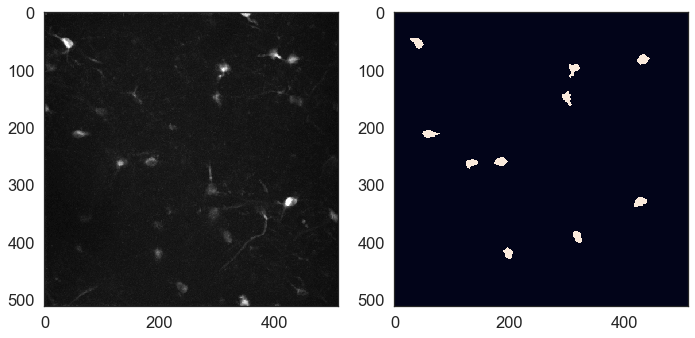

In [133]:
# plot the max intensity projection and the segmentation mask
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax[0].imshow(ophys_experiment.max_projection, cmap='gray')
ax[1].imshow(ophys_experiment.segmentation_mask_image)
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">   
 
<p><b>Task 3.2 continued</b></p>
<p>3) What is the index of the <code>cell_specimen_table</code> attribute? </p>
<p>4) Get and display the mask for a single cell from the <code>roi_mask</code> column in the <code>cell_specimen_table</code> attribute. What other columns does cell <code>cell_specimen_table</code> have? </p>
</div>

In [134]:
# get cell_specimen_table attribute of ophys_experiment
cell_specimen_table = ophys_experiment.cell_specimen_table.copy()

In [135]:
# what does cell_specimen_table look like? 
cell_specimen_table.head()

cell_roi_id  height  mask_image_plane  max_correction_down  \
cell_specimen_id                                                               
1086611645         1080742677      22                 0                  3.0   
1086611670         1080742681      17                 0                  3.0   
1086611915         1080742683      18                 0                  3.0   
1086611955         1080742684      17                 0                  3.0   
1086612075         1080742685      13                 0                  3.0   

                  max_correction_left  max_correction_right  \
cell_specimen_id                                              
1086611645                       15.0                   2.0   
1086611670                       15.0                   2.0   
1086611915                       15.0                   2.0   
1086611955                       15.0                   2.0   
1086612075                       15.0                   2.0   

                  max_correction_up  valid_roi  width    x    y  \
cell_specimen_id                                                  
1086611645                     27.0       True     18  190  409   
1086611670                     27.0       True     23  418  323   
1086611915                     27.0       True     21  125  255   
1086611955                     27.0       True     23  175  252   
1086612075                     27.0       True     31   49  206   

                                                           roi_mask  
cell_specimen_id                                                     
1086611645        [[False, False, False, False, False, False, Fa...  
1086611670        [[False, False, False, False, False, False, Fa...  
1086611915        [[False, False, False, False, False, False, Fa...  
1086611955        [[False, False, False, False, False, False, Fa...  
1086612075        [[False, False, False, False, False, False, Fa...

In [136]:
# what are the columns?
cell_specimen_table.columns

Index(['cell_roi_id', 'height', 'mask_image_plane', 'max_correction_down',
       'max_correction_left', 'max_correction_right', 'max_correction_up',
       'valid_roi', 'width', 'x', 'y', 'roi_mask'],
      dtype='object')

In [137]:
# get a random cell_specimen_id
random_index = np.random.randint(0, high = len(cell_specimen_table) - 1, size = 1)[0]
random_cell_specimen_id = cell_specimen_table.index[random_index]

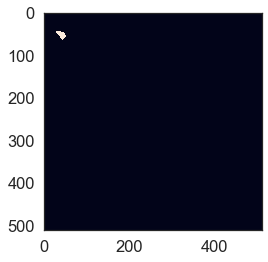

In [138]:
# plot the roi_mask for this cell_specimen_id
plt.imshow(cell_specimen_table["roi_mask"][random_cell_specimen_id])

    
<p>The <code>cell_specimen_table</code> contains information about each segmented cell in an ophys experiment. The index of this table is the <code>cell_specimen_id</code>, which is the unified ID of each cell after cells have been matched across experiments. This is the ID you will want to use for most analysis.</p>
<p>The important columns in the <code>cell_specimen_table</code> for you to know about are: </p>
<p><code>cell_roi_id</code>: the unique identifier of each segmented ROI in the ophys_experiment. This ID is not matched across sessions. </p>
<p><code>roi_mask</code>: a binary mask image representing the location and shape of the segmented cell within the 2-photon field of view.  </p> 
<p><code>x</code>: The centroid location of the ROI along the x-axis of the 2-photon image. </p>
<p><code>y</code>: The centroid location of the ROI along the y-axis of the 2-photon image. </p>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.3: Get dF/F traces and ophys timestamps</b></p>

<p>1) Get <code>dff_traces</code> and <code>ophys_timestamps</code> attributes. How are they formatted?    </p>

</div>

In [139]:
# get traces and timestamps
dff_traces = ophys_experiment.dff_traces
ophys_timestamps = ophys_experiment.ophys_timestamps

In [140]:
# what does the dff_traces attribute look like? 
dff_traces.head()

cell_roi_id  \
cell_specimen_id                
1086611645         1080742677   
1086611670         1080742681   
1086611915         1080742683   
1086611955         1080742684   
1086612075         1080742685   

                                                                dff  
cell_specimen_id                                                     
1086611645        [0.1781090497970581, 0.4916941523551941, 0.370...  
1086611670        [0.11838669329881668, 0.24040241539478302, 0.1...  
1086611915        [0.2092573642730713, 0.1468382477760315, 0.117...  
1086611955        [0.15405845642089844, 0.41861066222190857, 0.1...  
1086612075        [0.2626180946826935, 0.4356040060520172, 0.294...

In [141]:
# what does the timestamps attribute look like? 
ophys_timestamps

array([   9.33347,    9.42667,    9.51988, ..., 4513.69518, 4513.78842,
       4513.88165])

<p><code>dff_traces</code> is a dataframe with <code>cell_specimen_id</code> as the index and a column called <code>dff</code> which contains the baseline normalized fluorescence traces, also called dF/F traces, for each cell in the <code>ophys_experiment</code>. </p>
    
<p><code>ophys_timestamps</code> is an array of timestamps corresponding to each 2P imaging frame. </p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>2) Check that the length of one of the dF/F traces is the same length as the ophys timestamps.</p>
</div>

In [142]:
# get shape of traces and timestamps
print('shape of dff_traces:',dff_traces.shape)
print('shape of ophys_timestamps:',ophys_timestamps.shape)

shape of dff_traces: (10, 2)
shape of ophys_timestamps: (48316,)


In [143]:
# length of one cell's trace
print('length of one trace:', len(dff_traces.iloc[0]["dff"]))

length of one trace: 48316


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.4: Plot the dF/F trace for a cell</b></p>

<p>1) Plot the dF/F trace for one cell by indexing into the <code>dff_traces</code> array. You can get a specific row of the dataframe with .iloc, or use the <code>cell_specimen_id</code> to index with the .loc method. 
    
 __[Difference between .iloc and .loc](https://stackoverflow.com/questions/31593201/how-are-iloc-ix-and-loc-different)__ </p>
    
<p>2) Use <code>ophys_timestamps</code> to plot the x-axis in seconds. </p>
    
<p>3) Try plotting the trace for a few different cells.</p>

</div>

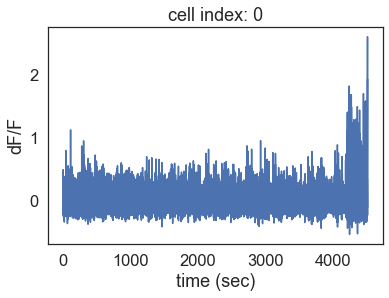

In [144]:
# plot the dF/F trace for one cell using ophys timestamps for x-axis values
# indexing method using row index with .iloc
cell_index = 0 
dff_trace = dff_traces.iloc[cell_index]['dff'] # note that the column name is outside of the .iloc call
plt.plot(ophys_timestamps, dff_trace)
plt.xlabel('time (sec)');
plt.ylabel('dF/F');
plt.title('cell index: '+str(cell_index));

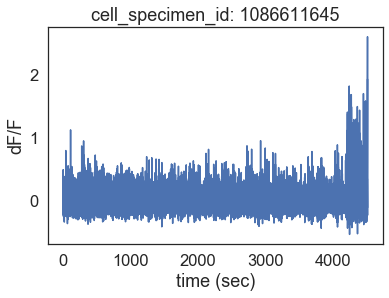

In [145]:
# plot the dF/F trace for one cell using ophys timestamps for x-axis values
# indexing method using cell_specimen_id as index with .loc

# get cell_specimen_id from a list of all cell_specimen_ids
cell_specimen_ids = dff_traces.index.values
cell_specimen_id = cell_specimen_ids[cell_index]

dff_trace = dff_traces.loc[cell_specimen_id, 'dff'] #note how the column name is included in the .loc call
plt.plot(ophys_timestamps, dff_trace)
plt.xlabel('time (sec)');
plt.ylabel('dF/F');
plt.title('cell_specimen_id: '+str(cell_specimen_id));

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 3.5: Plot a heatmap of all cell traces in this session</b></p>

<p>1) Extract the <code>dff_traces</code> from the dataframe into an array. What is the shape?</p>

<p>2) Use the matplotlib plotting function <code>pcolormesh</code> to plot the matrix as a heatmap. Plot the x-axis in seconds.</p>

</div>

In [146]:
# convert dff_traces from a dataframe to an array of cells x timepoints
dff_traces_array = np.vstack(dff_traces["dff"].values)
print('shape of dff_traces_array:',dff_traces_array.shape)

shape of dff_traces_array: (10, 48316)


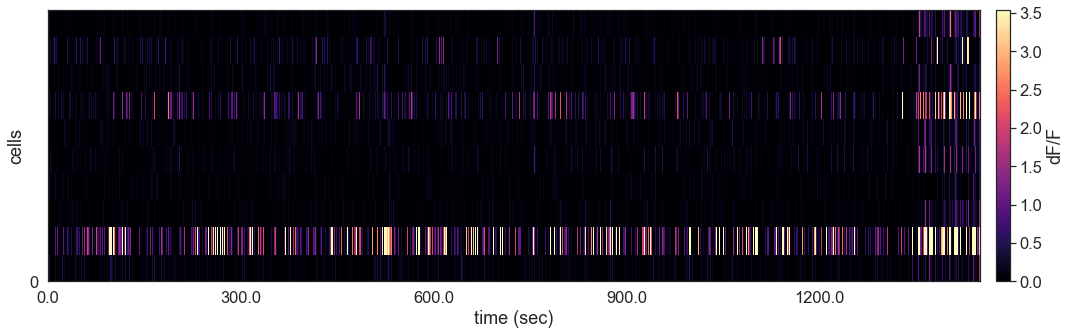

In [147]:
# plot heatmap of all cell traces in this experiment
fig, ax = plt.subplots(figsize = (20,5))

cax = ax.pcolormesh(dff_traces_array,
                    vmin = 0, vmax = np.percentile(dff_traces_array, 99),
                    cmap = 'magma')

# label axes 
ax.set_ylabel('cells')
ax.set_xlabel('time (sec)')

# x ticks
ax.set_yticks(np.arange(0, len(dff_traces_array), 10));
ax.set_xticklabels(np.arange(0, ophys_timestamps[-1], 300));

# creating a color bar
cb = plt.colorbar(cax, pad=0.015, label='dF/F')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior timeseries and events - running, licks, and rewards </h2>
<p>As the mouse performs the behavioral task, it is free to run on a disk. The task is a go/no-go style task with licking as the behavioral response. When a mouse correctly licks the water spout, a reward is delivered. </p>

<p>Running, licks and rewards are measured at the stimulus frame display rate and share timestamps with the stimulus. </p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.1: Get running speed trace and timestamps</b></p>

<p>1) Get the <code>running_speed</code> attribute of the dataset object. What does it contain? </p>

<p>2) Compare the values of running timestamps from  <code>running_speed</code> with the values in the dataset attribute <code>stimulus_timestamps</code>. Note that all timestamps are in seconds. </p>
    
</div>

In [148]:
# get running speed
ophys_experiment.running_speed.head()

timestamps     speed
0     6.87653  0.039084
1     9.28021  1.448758
2     9.29687  2.724152
3     9.31357  3.763775
4     9.33024  4.505150

In [149]:
# what are the values of running speed timestamps?
print('running speed timestamps:', ophys_experiment.running_speed["timestamps"].values)

running speed timestamps: [   6.87653    9.28021    9.29687 ... 4513.77764 4513.79435 4513.81103]


In [150]:
# what are the values of stimulus timestamps?
print('stimulus timestamps:', ophys_experiment.stimulus_timestamps)

stimulus timestamps: [   6.87653    9.28021    9.29687 ... 4513.77764 4513.79435 4513.81103]


<code>running_speed</code> timestamps should match the <code>stimulus_timestamps</code>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.2: Plot running speed</b></p>

<p>2) Plot the values for <code>running_speed</code> with time in seconds on the x-axis. </p>
    
<p>Running speed is measured in cm/s. Label the axes appropriately.</p>
        
</div>

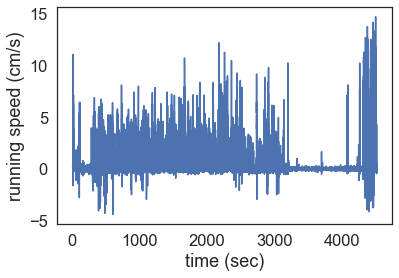

In [151]:
# plot running speed with timestamps on x-axis
# dont forget to label your axes!
plt.plot(ophys_experiment.running_speed["timestamps"], 
         ophys_experiment.running_speed["speed"])

# axes labels
plt.ylabel('running speed (cm/s)');
plt.xlabel('time (sec)');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.3: Rewards and licks</b></p>
    
<p>1) Get the <code>rewards</code> attribute of the session object. How is it formatted? </p>

<p>2) Get the <code>licks</code> attribute of the session object. How is it formatted? </p>
    
</div>

In [152]:
# Get information about rewards
ophys_experiment.rewards.head()

volume  timestamps  autorewarded
0   0.005   322.91986          True
1   0.005   333.44514          True
2   0.005   364.23697          True
3   0.005   388.25660          True
4   0.005   455.04450          True

In [153]:
# Get information about licks
ophys_experiment.licks.head()

timestamps  frame
0    11.53201    136
1    11.68216    145
2    11.84896    155
3    11.99908    164
4    12.14920    173

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 4.4: Plot licking, reward times, and running speed</b>
    
<p>1) Plot <code>running_speed</code> as above, but set xlims to focus on a 30 second portion of the behavior session (ex: from x=600 to x=630). </p>

<p>2) On the same plot, plot <code>rewards</code> as points (not a line), at y = -10. Note that <code>rewards</code> is a dataframe, with timestamps as the index. Use the values of the index to get the times of all rewards to plot along the x-axis.</p>

<p>Hint: You will need to create an array of len(session.rewards) filled with -10 to use as y-axis values to plot. np.repeat() is a convenient function for this.</p>

<p>3) Add times of <code>licks</code> using plt.vlines() to your plot, with ymin=-10 and ymax=-5. </p>

<p>What is the relationship between running, licking and rewards? </p>
    
</div>

In [154]:
# plot running_speed, rewards, and licks on the same plot


In [155]:
# Hint for plotting rewards using np.repeat()
# plt.plot(ophys_experiment.rewards.index.values, 
#          np.repeat(-10, len(ophys_experiment.rewards)))


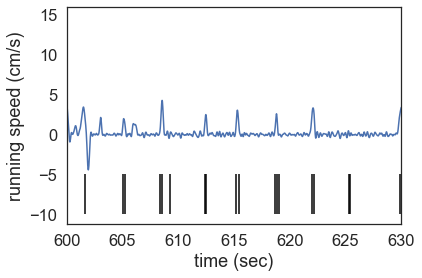

In [156]:
# running speed
plt.plot(ophys_experiment.running_speed["timestamps"], 
         ophys_experiment.running_speed["speed"])

plt.xlim(600,630)

# axes labels
plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')

# rewards / licks
plt.plot(ophys_experiment.rewards.index.values, 
         np.repeat(-10, len(ophys_experiment.rewards)))

plt.vlines(ophys_experiment.licks,
           ymin = -10, ymax = -5,
           color = 'black')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Visual stimuli </h2>
    
<p>The timing of visual stimui can be accessed through the <code>stimulus_presentations</code> table. This includes the timing of omitted stimuli - in other words, the time where the image would have been presented if it were not omitted. </p> 
    
<p>The images shown during the session are included in the <code>stimulus_templates</code>. </p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.1: Get the stimulus table</b></p>

<p>1) Get the <code>stimulus_presentations</code> attribute to identify the times of stimulus presentations. How many stimulus flashes were there? </p>

<p>What other data is included for each stimulus flash in this table? What could it be used for?</p>
    
</div>

In [157]:
# get the stimulus presentations table
ophys_experiment.stimulus_presentations.head()

start_time  stop_time  duration image_name  \
stimulus_presentations_id                                               
0                           309.27537  309.52557   0.25020      im065   
1                           310.02598  310.27619   0.25021      im065   
2                           310.77660  311.02680   0.25020      im065   
3                           311.52721  311.77740   0.25019      im065   
4                           312.27782  312.52806   0.25024      im065   

                           image_index  is_change  omitted  start_frame  \
stimulus_presentations_id                                                 
0                                    0      False    False        17986   
1                                    0      False    False        18031   
2                                    0      False    False        18076   
3                                    0      False    False        18121   
4                                    0      False    False        18166   

                           end_frame  \
stimulus_presentations_id              
0                            18001.0   
1                            18046.0   
2                            18091.0   
3                            18136.0   
4                            18181.0   

                                                                   image_set  
stimulus_presentations_id                                                     
0                          Natural_Images_Lum_Matched_set_training_2017.0...  
1                          Natural_Images_Lum_Matched_set_training_2017.0...  
2                          Natural_Images_Lum_Matched_set_training_2017.0...  
3                          Natural_Images_Lum_Matched_set_training_2017.0...  
4                          Natural_Images_Lum_Matched_set_training_2017.0...

In [158]:
# how many stimulus presentations were there? 
print('number of stimulus presentations =', len(ophys_experiment.stimulus_presentations))

number of stimulus presentations = 4801


In [159]:
# what are the columns of the stimulus presentations table?
ophys_experiment.stimulus_presentations.columns

Index(['start_time', 'stop_time', 'duration', 'image_name', 'image_index',
       'is_change', 'omitted', 'start_frame', 'end_frame', 'image_set'],
      dtype='object')

<p><b>Info on <code>stimulus_presentations</code> columns:</b></p>

There are 8 images presented in each session, for a total of 64 possible image transitions. 

The <code>is_change</code> column indicates which stimulus presentations were image changes where the previous stimulus presentation <code>image_name</code> and the current stimulus presentation <code>image_name</code> are different. 

During ophys sessions (but not during training), 5% of all non-change or pre-change stimulus presentations are randomly omitted. Omitted stimuli are denoted in the <code>stimulus_table</code> by the <code>omitted</code> column. True means that the stimulus that would have been shown at that time was actually omitted (and was replaced by an extended gray screen between stimuli).

Stimulus omissions are also indicated in the <code>image_name</code> column by the string "omitted"

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.2: Plot visual stimulus presentations with behavior events</b></p>

<p>1) Copy and paste your code from Task 4.4</p>

<p>2) On the same plot, plot stimulus presentations using the <code>start_time</code> and <code>stop_time</code> columns with plt.axvspan(). Set alpha=0.3 & facecolor='gray'.</p>

<p>Hint: Loop through each row of the <code>stimulus_presentations</code> table to plot all stimulus presentations.
    
<p>3) Bonus: Plot stimulus presentations corresponding to image changes using the <code>is_change</code> column. Set facecolor = 'green' to distinguish from non-change flashes. </p>

</div>

In [160]:
# plot running_speed, licks, rewards, and visual stimuli


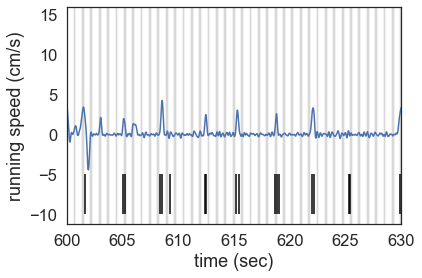

In [161]:
# running speed
plt.plot(ophys_experiment.running_speed["timestamps"], 
         ophys_experiment.running_speed["speed"])

plt.xlim(600,630)

# axes labels
plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')

# rewards / licks
plt.plot(ophys_experiment.rewards.index.values, 
         np.repeat(-10, len(ophys_experiment.rewards)))

plt.vlines(ophys_experiment.licks,
           ymin = -10, ymax = -5,
           color = 'black')

# save stimulus_presentations attribute to a new variable 
stimulus_presentations = ophys_experiment.stimulus_presentations.copy()
# axvspan to delineate periods where a stimulus was shown
for stimulus_presentations_id in stimulus_presentations.index.values:
    row_data = stimulus_presentations.loc[stimulus_presentations_id]
    plt.axvspan(row_data["start_time"], row_data["stop_time"],
                alpha=0.3, facecolor ='gray')
    if row_data["is_change"]:
        plt.axvspan(row_data["start_time"], row_data["stop_time"],
                    alpha=0.3, facecolor ='green')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.3: Get visual stimulus templates</b>

<p>1) Get the <code>stimulus_templates</code> table from the session object. How is it formatted? </p>

    
<p>2) Plot both the unwarped and warped image from <code>stimulus_templates</code>. Show the name of the image in the title.</p>
    
</div>

In [162]:
# get the stimulus templates attribute
ophys_experiment.stimulus_templates

unwarped  \
image_name                                                      
im065       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im077       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im066       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im061       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im063       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im062       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im085       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im069       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                       warped  
image_name                                                     
im065       [[198, 197, 201, 207, 207, 202, 198, 201, 207,...  
im077       [[129, 135, 140, 142, 140, 135, 129, 124, 117,...  
im066       [[83, 85, 82, 78, 78, 81, 84, 84, 82, 82, 84, ...  
im061       [[125, 126, 126, 126, 125, 125, 125, 125, 125,...  
im063       [[105, 108, 107, 101, 97, 96, 98, 101, 103, 10...  
im062       [[103, 103, 103, 105, 112, 125, 145, 172, 204,...  
im085       [[54, 56, 50, 45, 45, 51, 56, 55, 51, 48, 49, ...  
im069       [[251, 248, 255, 255, 255, 254, 246, 248, 255,...

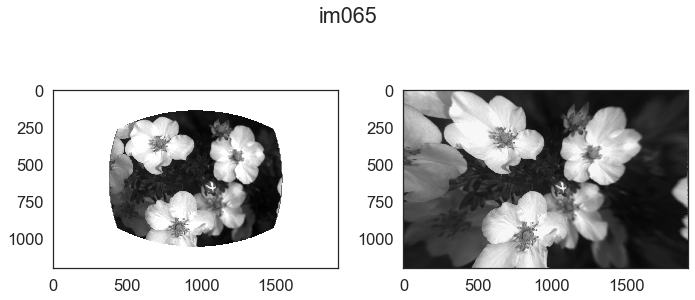

In [163]:
# plot the warped and unwarped images for one image_name in stimulus_templates using .imshow()

first_image = ophys_experiment.stimulus_templates.index[0]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
ax[0].imshow(ophys_experiment.stimulus_templates['unwarped'][first_image], cmap='gray')
ax[1].imshow(ophys_experiment.stimulus_templates['warped'][first_image], cmap = 'gray')

plt.suptitle(first_image)
plt.tight_layout()

<p><b>Info on warped and unwarped images</b></p>

<p> During the experiment, the mouse's right eye is centered on the monitor, such that the center of the screen is closest to the eye and edges of the screen are further away. Visual stimuli presented to the mice have spherical warping applied to ensure consistent size and spatial frequency as the screen gets further from the mouse's eye. </p>
    
<p>The warped images are what was presented on the screen. The unwarped images are what the stimulus looked like to the mouse.</p>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior trials data</h2>
    
<p>The <code>trials</code> dataframe organizes behavior events (including licking and rewards), stimulus information (what stimulus was shown before and after the scheduled change time) and metadata (such as whether the trial was a 'go' trial or a 'catch' trial) for each behavioral trial.</p>

<p>This structure is convenient for data exploration and analysis.</p>

<img src="../../resources/visual_behavior/Trial_diagramC.png"> 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.1: Explore the trials table</b></p>

<p>1) Get the <code>trials</code> attribute. What are the columns of this dataframe? What are the rows?</p>

<p>2) How many go trials were there? How many catch trials? What is the ratio of go to catch trials?</p>

<p>3) What images were shown? Use the pandas <code>.unique()</code> method to get the unique images from the trials table. </p>
</div>

In [164]:
# get the trials table 
trials = ophys_experiment.trials
trials.head()

initial_image_name change_image_name  stimulus_change  change_time  \
trials_id                                                                      
0                      im065             im065            False          NaN   
1                      im065             im065            False          NaN   
2                      im065             im065            False          NaN   
3                      im065             im065            False          NaN   
4                      im065             im069             True   322.822945   

              go  catch                                         lick_times  \
trials_id                                                                    
0          False  False                                        [311.41045]   
1          False  False                                        [313.84577]   
2          False  False                                        [316.33114]   
3          False  False                                        [319.30022]   
4          False  False  [323.22008, 323.38691, 323.75386, 323.90398, 3...   

           response_time  response_latency  reward_time  ...    hit  \
trials_id                                                ...          
0                    NaN               NaN          NaN  ...  False   
1                    NaN               NaN          NaN  ...  False   
2                    NaN               NaN          NaN  ...  False   
3                    NaN               NaN          NaN  ...  False   
4              323.22008          0.397135    322.91986  ...  False   

           false_alarm   miss  correct_reject  aborted  auto_rewarded  \
trials_id                                                               
0                False  False           False     True          False   
1                False  False           False     True          False   
2                False  False           False     True          False   
3                False  False           False     True          False   
4                False  False           False    False           True   

           change_frame  start_time  stop_time  trial_length  
trials_id                                                     
0                   NaN   309.25866  311.72736       2.46870  
1                   NaN   312.26114  314.16270       1.90156  
2                   NaN   314.51298  316.64807       2.13509  
3                   NaN   316.76480  319.61716       2.85236  
4               18795.0   319.76729  327.03990       7.27261  

[5 rows x 21 columns]

In [165]:
len(trials)

759

In [166]:
# how many go trials were there? 
print('number of go trials =',len(trials[trials["go"] == True]))

number of go trials = 181


In [167]:
# how many catch trials were there?
print('number of catch trials =',len(trials[trials["catch"] == True]))

number of catch trials = 28


In [168]:
# what images were shown? 
images = trials["change_image_name"].unique()
print(images)

['im065' 'im069' 'im062' 'im077' 'im066' 'im063' 'im085' 'im061']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.2: Get the hit and false alarm rates for this session</b></p>

<p>The hit rate is the fraction of go trials with a lick in the reward window</p>
    
<p>The false alarm rate is the fraction of catch trials with a lick in the reward window</p>

<p>1) Select all the go trials by filtering the dataframe by <code>go</code> = True. Get the fraction of go trials where <code>hit</code> = True. </p>

<p>2) Repeat for catch trials.</p>

</div>

In [169]:
# compute the hit rate for go trials
go_trials = trials[trials["go"] == True]
print(len(go_trials), 'go trials')

print(np.sum(go_trials["hit"]), 'hits')
print('hit rate:', round(np.sum(go_trials["hit"])/len(go_trials),2))

181 go trials
66 hits
hit rate: 0.36


In [170]:
# compute the false alarm rate for catch trials
catch_trials = ophys_experiment.trials[ophys_experiment.trials.catch]
print(len(catch_trials),'catch trials')
print(np.sum(catch_trials.false_alarm),'false alarms')
print('false alarm rate:',round(np.sum(catch_trials.false_alarm)/len(catch_trials),2))

28 catch trials
4 false alarms
false alarm rate: 0.14


In [171]:
# did your mouse do a good job at the task? 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.3: Plot a lick raster across trials aligned to the change time</b></p>

<p>1) Provide the <code>trials</code> dataframe to the function below to plot a lick raster.</p>

<p>Is the mouse performing the task consistently across the whole session?</p>
</div>

In [172]:
def make_lick_raster(trials):
    #subset data to remove aborted trials
    trials = trials[trials["aborted"] == False]
    trials = trials.reset_index()
    
    fig,ax = plt.subplots(figsize=(5,10))
    for trial_index, trial_id in enumerate(trials.index.values): 
        trial_data = trials.loc[trial_id]
        # get times relative to change time
        lick_times = [(t - trial_data["change_time"]) for t in trial_data["lick_times"]]
        reward_time = [(t - trial_data["change_time"]) for t in [trial_data["reward_time"]]]
        
        # plot reward times
        if len(reward_time)>0:
               ax.plot(reward_time[0], trial_index + 0.5, 
                    '.', color='b', label='reward', markersize = 6)
        
        # plot lick times
        ax.vlines(lick_times, trial_index, 
                  trial_index + 1, color='k', linewidth=1)
        
        # put a line at the change time
        ax.vlines(0, trial_index, trial_index + 1, 
                  color=[.5, .5, .5], linewidth = 1)
    
    # gray bar for response window
    ax.axvspan(0.1, 0.7, facecolor = 'gray', alpha = .3, edgecolor = 'none')
    ax.grid(False)
    
    
    ax.set_xlim([-1, 4])
    ax.set_ylim(0, len(trials))

    
    ax.set_xlabel('time relative to change (sec)')
    ax.set_ylabel('trials')

    ax.set_title('lick raster')
    plt.gca().invert_yaxis()

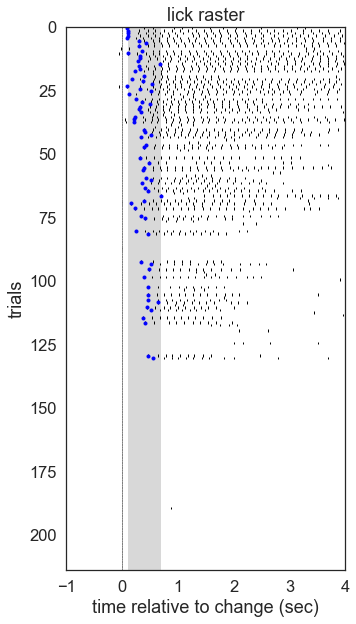

In [173]:
# plot the lick raster for this session using the provided function

make_lick_raster(ophys_experiment.trials)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Reminder:</b>You can find a description of all <code>behavior_session</code> and <code>ophys_experiment</code> attributes, and their columns, in the Visual Behavior cheat sheet or the SDK documentation provided here:</p>
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf</a></p>  
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf</a></p>  
</div>